## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)
sys.modules['dostools.src'] = dostools

In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


## Evaluator

In [3]:
import dostools.evaluation.evaluation as evaluation
importlib.reload(evaluation)
import dostools.models.training as training
importlib.reload(training)

targets = {
    'pw' : ldos,
    'lcdf' : y_lcdf,
    'pc' : y_pc
}
evaluator = evaluation.Evaluator(targets, xdos, mean_dos_per_atom)

## Dataset and DataLoader

In [12]:
import dostools.datasets.dataset as data
from torch.utils.data import TensorDataset, DataLoader
import dostools.consistency.consistency as consistency

device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}
#Dataset
y_shifted = copy.deepcopy(y_pw)
#y_shifted[train_index][:100] = consistency.shifted_ldos(y_shifted[:100], xdos, torch.zeros(100)-10)
train_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][train_index[:100]].double(), y_shifted[train_index[:100]].double())
train_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][train_index[:100]].double(), y_shifted[train_index[:100]].double())

test_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][test_index].double(), y_shifted[test_index].double())
test_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][test_index].double(), y_shifted[test_index].double())

#Dataloader

train_dataloader_soap = DataLoader(train_data_soap, batch_size = 4, shuffle = True, **kwargs)
train_dataloader_kernel = DataLoader(train_data_kernel, batch_size = 4, shuffle = True, **kwargs)



## Loss Function

In [26]:
import dostools.src.consistency.consistency as consistency
import dostools.src.loss.loss as loss
importlib.reload(loss)
importlib.reload(consistency)

def t_get_BF_shift_index_mse(prediction, true, shift_range, xdos = None, perc = False):
    if xdos is not None:
        mse = torch.zeros(true.shape[0])
        index = torch.zeros(true.shape[0])
        for i, pred in enumerate((prediction)):
            shifted_preds = consistency.shifted_ldos(pred.repeat(shift_range.shape[0],1), xdos, shift_range)
            mse[i], index[i] = torch.min(loss.t_get_each_mse(shifted_preds, true[i].repeat(shift_range.shape[0],1)),0)
        mse = torch.mean(mse, 0)
        
        return mse,index        
    else:
        raise ValueError("xdos not defined")

def t_get_wasserstein_shift(prediction, true):
    if len(prediction.size()) > 1:
        u_values = prediction
        v_values = true

        u_sorted, _ = torch.sort(u_values, dim = 1)
        v_sorted, _ = torch.sort(v_values, dim = 1)

        all_values = torch.concatenate((u_values, v_values), dim = 1)
        all_values, _ = all_values.sort(dim = 1)

        deltas = torch.diff(all_values, dim =1)

        u_cdf_indices = torch.searchsorted(u_sorted.contiguous(), all_values[:,:-1], side = 'right')
        v_cdf_indices = torch.searchsorted(v_sorted.contiguous(), all_values[:,:-1], side = 'right')

        u_cdf = u_cdf_indices / u_values.numel()

        v_cdf = v_cdf_indices / v_values.numel()

        result = torch.sum(torch.multiply(torch.abs(u_cdf - v_cdf),deltas))

        return (result)
        
    else:
        u_values = prediction
        v_values = true

        u_sorted, _ = torch.sort(u_values)
        v_sorted, _ = torch.sort(v_values)

        all_values = torch.concatenate((u_values, v_values))
        all_values, _ = all_values.sort(dim = 0)

        deltas = torch.diff(all_values) 

        u_cdf_indices = torch.searchsorted(u_sorted, all_values[:-1], side = 'right')
        v_cdf_indices = torch.searchsorted(v_sorted, all_values[:-1], side = 'right')

        u_cdf = u_cdf_indices / u_values.numel()

        v_cdf = v_cdf_indices / v_values.numel()

        result = torch.sum(torch.multiply(torch.abs(u_cdf - v_cdf),deltas))

        return (result)


In [27]:
xdos_step = xdos[1] - xdos[0]
shift_range = torch.tensor([x*xdos_step for x in range(-778,778)])
shifted_preds = consistency.shifted_ldos(y_pw[1].repeat(shift_range.shape[0],1), xdos, shift_range)
all_mse = loss.t_get_each_mse(shifted_preds, y_pw[0].repeat(shift_range.shape[0],1))
mse, index = torch.min(all_mse,0)


## Testing out scipy's alignment

In [28]:
u_values = y_pw[1]
v_values = y_shifted[1]

u_sorted, _ = torch.sort(u_values)
v_sorted, _ = torch.sort(v_values)

all_values = torch.concatenate((u_values, v_values))
all_values, _ = all_values.sort(dim = 0)

deltas = torch.diff(all_values) 

u_cdf_indices = torch.searchsorted(u_sorted, all_values[:-1], side = 'right')
v_cdf_indices = torch.searchsorted(v_sorted, all_values[:-1], side = 'right')

u_cdf = u_cdf_indices / u_values.numel()

v_cdf = v_cdf_indices / v_values.numel()

result = torch.sum(torch.multiply(torch.abs(u_cdf - v_cdf),deltas))

print (result)

tensor(0.)


In [143]:
u_values = y_pw
v_values = y_shifted

u_sorted, _ = torch.sort(u_values, dim = 1)
v_sorted, _ = torch.sort(v_values, dim = 1)

all_values = torch.concatenate((u_values, v_values), dim = 1)
all_values, _ = all_values.sort(dim = 1)

deltas = torch.diff(all_values, dim =1)

u_cdf_indices = torch.searchsorted(u_sorted.contiguous(), all_values[:,:-1], side = 'right')
v_cdf_indices = torch.searchsorted(v_sorted.contiguous(), all_values[:,:-1], side = 'right')

u_cdf = u_cdf_indices / u_values.numel()

v_cdf = v_cdf_indices / v_values.numel()

result = torch.sum(torch.multiply(torch.abs(u_cdf - v_cdf),deltas))

print (result)

tensor(0.)


In [137]:
u_sorted.shape

torch.Size([1039, 778])

In [138]:
v_sorted.shape

torch.Size([1039, 778])

In [ ]:
#Can train on just this metric or convert to shifts

In [70]:
u_cdf_indices.shape

torch.Size([778])

In [65]:
u2 = y_pw[0].numpy()
v2 = y_shifted[0].numpy()

u2_s = np.argsort(u2)
v2_s = np.argsort(v2)

av = np.concatenate((u2,v2))
av.sort(kind='mergesort')

d = np.diff(av)

u_cdf_i = u2[u2_s].searchsorted(av[:-1], 'right')
v_cdf_i = v2[v2_s].searchsorted(av[:-1], 'right')

u_c = u_cdf_i / u2.size
v_c = v_cdf_i / v2.size

r = np.sum(np.multiply(np.abs(u_c - v_c), d))

In [69]:
u_cdf_i.shape

(1555,)

In [67]:
np.abs(u_c - v_c).shape

(1555,)

In [61]:
r

1.0565957960197742e-14

In [62]:
d.shape

(1555,)

In [30]:
a = np.array([[1,2,3,4,5],[1,2,3,4,7]])

In [31]:
a.size

10

In [36]:
y_pw[0].numel()

778

In [ ]:
#Try for 2 different distributions

## Evaluation Function

In [29]:
def t_get_rmse(a, b, xdos=None, perc=False): #account for the fact that DOS is continuous but we are training them pointwise
    """ computes  Root Mean Squared Error (RMSE) of array properties (DOS/aofd).
         a=pred, b=target, xdos, perc: if False return RMSE else return %RMSE"""
    #MIGHT NOT WORK FOR PC
    if xdos is not None:
        rmse = torch.sqrt(torch.trapezoid((a - b)**2, xdos, axis=1)).mean()
        if not perc:
            return rmse
        else:
            mean = b.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((b - mean)**2, xdos, axis=1)).mean()
            return (100 * rmse / std)
    else:
        rmse = torch.sqrt(((a - b)**2).mean(dim =0))
        if not perc:
            return torch.mean(rmse, 0)
        else:
            return torch.mean(100 * (rmse / b.std(dim = 0,unbiased=True)), 0)

## Alignment Model

In [31]:
import dostools.src.models.models as models
import dostools.src.models.training as training
import dostools.src.models.architectures as architecture
import dostools.src.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)


class WassLinearModel(nn.Module):
    def __init__(self, inputSize, outputSize, train_size, xdos, reg, opt, device):
        super(WassLinearModel, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize, bias = False)
        self.xdos = xdos
        self.opt = opt
        self.device = device
        self.reg = torch.tensor(reg, requires_grad = False).to(self.device)
        #self.alignment = torch.zeros(train_size, device = self.device)
        self.to(self.device)

    def forward(self, x):
        """
        Performs the transformations to the features based on the model
        
        Args:
            x (tensor): input features
        
        Returns:
            tensor: output
        """
        out = self.linear(x)
        return out

    def fit(self, traindata_loader, valdata_loader, loss, lr ,n_epochs):
        """
        Fits the model based on the training data, early stopping is based on performance on training data (or validation data)
        Returns the loss history 
        
        Args:
            traindata_loader (DataLoader): Train dataloader
            valdata_loader (DataLoader): Validation dataloader
            loss (function): Loss function
            lr (float): Learning rate
            n_epochs (int): Max number of epochs
        
        Returns:
            list: Loss history of the training process
        """
        if self.opt == "Adam":
            opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
            if valdata_loader is not None:
                threshold = 1000
                scheduler_threshold = 100
            else:
                threshold = 1000
                scheduler_threshold = 100
            tol = 1e-4
        if self.opt == "LBFGS":
            opt = torch.optim.LBFGS(self.parameters(), lr = lr)
            if valdata_loader is not None:
                threshold = 2000
                scheduler_threshold = 2000
            else:
                threshold = 30
                scheduler_threshold = 5
            tol = 0
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
        best_state = copy.deepcopy(self.state_dict())
        lowest_loss = torch.tensor(9999)
        pred_loss = torch.tensor(0)
        trigger = 0
        loss_history =[]
        pbar = tqdm(range(n_epochs))
        
        fig, ax_list = plt.subplots(4,2)
        ax_list = ax_list.flatten()
        lines = []
        critical_indexes = np.arange(8)
        #critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
        for i in range(len(critical_indexes)):
            line, = ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.tensors[1][critical_indexes[i]], label = "Prediction")
            lines.append(line)
            z = ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.tensors[1][critical_indexes[i]], label = "True")
        fig.legend([line,z], labels = ["Predicted", "True"], loc = "lower center")
        for epoch in pbar:
            pbar.set_description(f"Epoch: {epoch}")
            if valdata_loader is not None:
                pbar.set_postfix(val_loss = lowest_loss.item(), trigger = trigger, train_loss = pred_loss.item())
            else:
                pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

            for x_data, y_data in traindata_loader:
                opt.zero_grad()
                x_data, y_data = x_data.to(self.device), y_data.to(self.device)
                if self.opt == "LBFGS":
                    def closure(predictions = False):
                        """
                        Function is necessary for LBFGS, returns the total loss of the model
                        
                        Args:
                            predictions (bool, optional): Returns prediction loss if true, returns total loss if False
                        
                        Returns:
                            tensor: Loss
                        """
                        opt.zero_grad()
                        _pred = self.forward(x_data)
                        _pred_loss = t_get_wasserstein_shift(_pred, y_data)#, self.xdos), perc = True)       
                        _pred_loss *= 1e7
                        #self.alignment = (self.alignment - 20) * (self.xdos[1] - self.xdos[0])
                        _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
                        _reg_loss = torch.sum(torch.pow(self.linear.weight,2))
                        _reg_loss *= self.reg.item()
                        _new_loss = _pred_loss + _reg_loss
                        _new_loss.backward()
                        # global z 
                        # z = (torch.sum(abs(self.linear.weight.grad)))
                        if predictions:
                            return _pred_loss
                        return _new_loss
                    opt.step(closure)
                    #print (z)
                    with torch.no_grad():
                        pred = self.forward(x_data)
                        pred_loss = t_get_wasserstein_shift(pred, y_data)
                        reg_loss = torch.sum(torch.pow(self.linear.weight,2))
                        reg_loss *= self.reg.item()
                        new_loss = pred_loss + reg_loss
                    if pred_loss >100000 or (pred_loss.isnan().any()) :
                        print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                        self.load_state_dict(best_state)
                        opt = torch.optim.LBFGS(self.parameters(), lr = lr)
                    if epoch %10 == 1:
                        loss_history.append(lowest_loss.item())
                elif self.opt == "Adam":
                    pred = self.forward(x_data)
                    pred_loss = t_get_wasserstein_shift(pred, y_data)#, self.xdos, perc = True)
                    new_loss = 1E7 * pred_loss
                    new_loss.backward()
                    opt.step()
                    if pred_loss >100000 or (pred_loss.isnan().any()) :
                        print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                        self.load_state_dict(best_state)
                        opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())


            with torch.no_grad():
                total_pred = self.forward(traindata_loader.dataset.tensors[0])
                total_loss = t_get_wasserstein_shift(total_pred, traindata_loader.dataset.tensors[1])
                new_loss = total_loss
                if lowest_loss - new_loss > tol: #threshold to stop training
                    best_state = copy.deepcopy(self.state_dict())
                    lowest_loss = new_loss
                    trigger = 0
                if epoch %1000 == 1:
                    loss_history.append(lowest_loss.item())
                for i in range(len(critical_indexes)):
                    lines[i].set_ydata(total_pred[critical_indexes[i]].detach().numpy())
                fig.suptitle("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
                fig.canvas.draw()
                fig.canvas.flush_events()
                scheduler.step(new_loss)
                
                
                
                
                if valdata_loader is not None:
                    new_loss = torch.zeros(1, requires_grad = False).to(self.device)
                    for x_val, y_val in valdata_loader:
                        x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                        val_pred = self.forward(x_val)
                        new_loss += loss(val_pred, y_val, self.xdos, perc = False)



                else:
                    trigger +=1
                    
                    if trigger > threshold:
                        self.load_state_dict(best_state)
                        print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                        return loss_history
        return loss_history

  0%|                                                                                                                                                                                    | 0/20000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


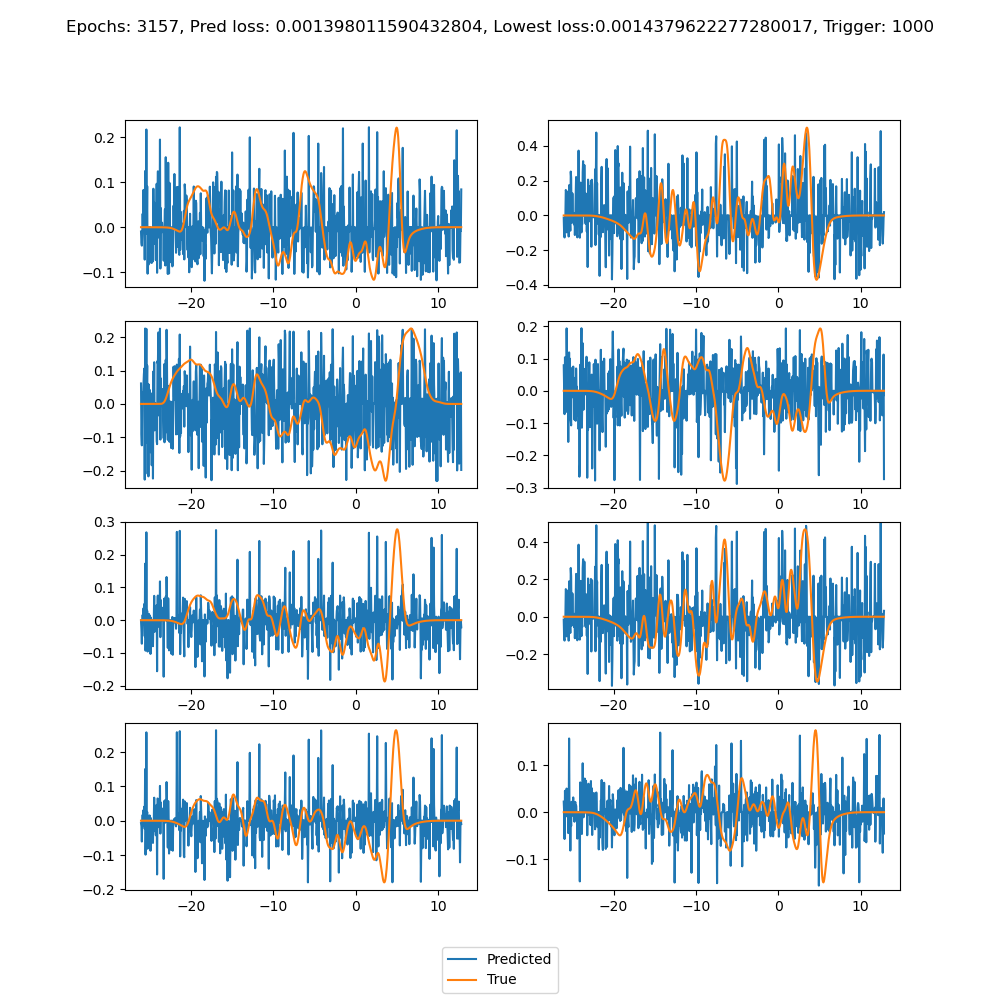

/tmp/ipykernel_573766/595645006.py:87: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([line,z], labels = ["Predicted", "True"], loc = "lower center")
Epoch: 3157:  16%|███████████████▎                                                                                 | 3157/20000 [9:01:37<48:09:40, 10.29s/it, lowest_loss=0.00144, pred_loss=0.00209, trigger=1000]

Implemented early stopping with lowest_loss: 0.0014379622277280017


In [32]:
#xdos_step = xdos[1] - xdos[0]
#shift_range = torch.tensor([x*xdos_step for x in range(-20,20)])
M_soap = WassLinearModel(448, 778, n_train, xdos, 1e-11, "Adam", "cpu")
loss_history = M_soap.fit(train_dataloader_soap,None, None, 0.001, 20000)

In [22]:
M_soap.alignment/xdos_step

tensor([-15., -16., -15.,  -8., -20., -19., -20.,   4.,  -5.,  -6.,  -3.,  -6.,
        -16.,  -8., -19.,  -5., -17., -16., -20., -18.,  -1.,   2., -18.,  -1.,
        -18., -18.,   4.,   5., -20.,  -8., -20.,   4.,   2., -17., -17., -17.,
        -18.,   6.,  -5., -19.,  -5.,  -3.,  -4., -17.,  -1.,  -8., -18.,  -1.,
         -1.,   1., -17.,  -6.,  -2., -20.,  -6., -20.,  -2.,   4.,   2., -18.,
        -18., -18., -17., -20.,  -5.,  -4., -17., -15., -17., -15.,  -4.,  -4.,
          4.,   3., -18.,  -4.,  -1., -20., -20.,   4., -15., -17.,  -4., -20.,
        -18., -19., -18., -11., -17.,   4.,   5., -19., -18., -15.,   4.,  -5.,
         -5., -20.,  -9., -20.,   3.,   3.,  -9., -20.,  -4., -15., -20.,  -4.,
        -18., -11., -20., -19.,  -1., -15.,  -6., -18., -18., -18.,  -2., -17.,
        -18., -20.,   4., -15., -18.,  -2., -15., -15.,  -5., -16.,  -6., -17.,
        -17., -16., -17.,  -5.,   6., -15., -19.,  -4.,  -1., -17., -16.,  -1.,
         -4.,  -9.,  -6., -18.,  -7.,  -